In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import pathlib

In [2]:
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

In [3]:
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = keras.utils.get_file(origin=dataset_url,
           fname = 'flower_photos',
            untar = True)
data_dir = pathlib.Path(data_dir)
print(data_dir)


228813984/228813984 [==============================] - 8s 0us/step
/root/.keras/datasets/flower_photos


In [4]:
train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=IMAGE_SHAPE,
  batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.


In [5]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


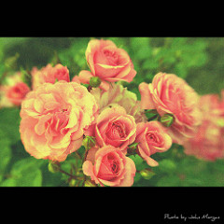

In [6]:
rose = list(data_dir.glob('roses/*'))[80]
rose = Image.open(str(rose)).resize(IMAGE_SHAPE)
rose

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [8]:
classifier_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
classifier = tf.keras.Sequential([
    # using tensorflow hub to download our model
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
print(imagenet_labels)

10484/10484 [==============================] - 0s 0us/step
['background' 'tench' 'goldfish' ... 'bolete' 'ear' 'toilet tissue']


In [10]:
rose = np.array(rose)/255.0
result = classifier.predict(rose[np.newaxis, ...])

1/1 [==============================] - 1s 1s/step


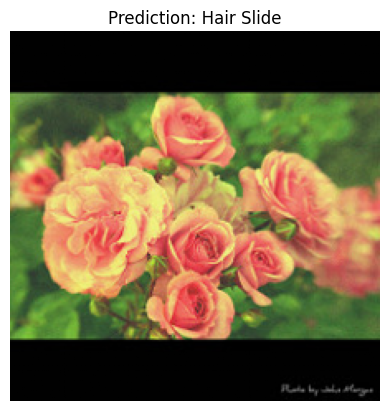

In [11]:
predicted_class = tf.math.argmax(result[0], axis=-1)
plt.imshow(rose)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [12]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [13]:
num_classes = len(class_names)
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [14]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [ ]:
NUM_EPOCHS = 10
history = model.fit(train_ds, epochs=NUM_EPOCHS)

Epoch 1/10
115/115 [==============================] - 130s 1s/step - loss: 0.7308 - acc: 0.7302
Epoch 2/10
115/115 [==============================] - 123s 1s/step - loss: 0.3466 - acc: 0.8864
Epoch 3/10
115/115 [==============================] - 123s 1s/step - loss: 0.2729 - acc: 0.9131
Epoch 4/10
 43/115 [==========>...................] - ETA: 1:15 - loss: 0.2408 - acc: 0.9273

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")